In [18]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches

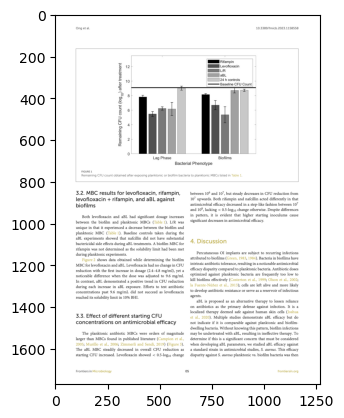

In [19]:
img_full = cv2.imread('./../../samples/imgPDF.png')
plt.imshow(img_full)

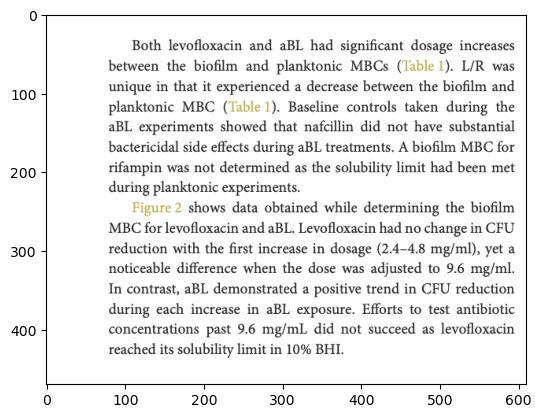

In [20]:
img = img_full[930:1400, 20:630]
plt.imshow(img)

### Preprocess

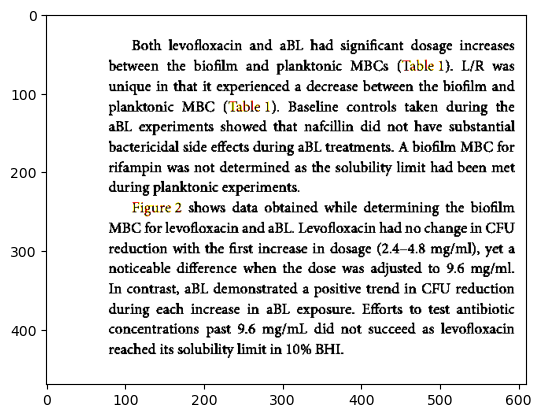

In [21]:
_,imgThresh1 = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
plt.imshow(imgThresh1,cmap='gray')

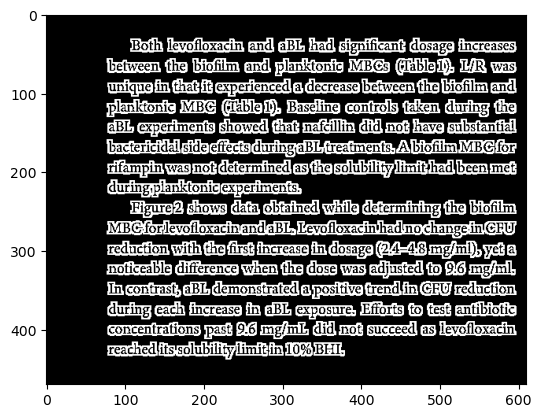

In [22]:
bs = 5
k = -0.2
maxval = 255
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgThresh2 = cv2.ximgproc.niBlackThreshold(img1,maxValue=maxval,
                                           type=cv2.THRESH_BINARY,blockSize=bs,k=k)
plt.imshow(imgThresh2,cmap='gray')

In [23]:
def preprocess(totalLabels,stats, centroids):
    #print(totalLabels,stats.shape,centroids.shape)
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    return df

In [24]:
def plot_components(df,comps=[]):
    output = img.copy() 
    for comp in comps:
        x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(output)

In [25]:
totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh2,4,cv2.CV_32S)
comp_df = preprocess(totalLabels,stats, centroid)
comp_df.shape

(373, 9)

In [26]:
comp_df_filtered = comp_df[(comp_df['area'] > 50) & (comp_df['aspect_ratio'] > 1.9) & (comp_df['area'] < 3000)]
comp_df_filtered.shape

(85, 9)

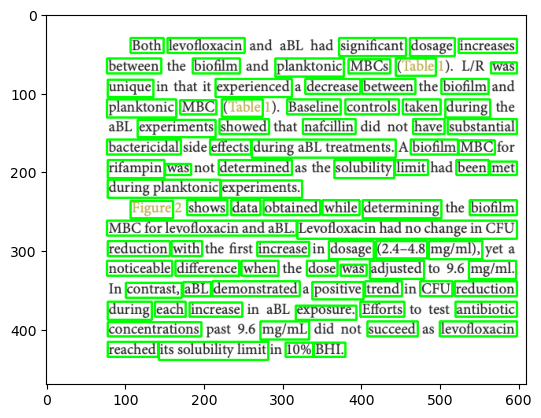

In [27]:
plot_components(comp_df_filtered,comps=comp_df_filtered.label_id.unique())

In [28]:
df = comp_df_filtered.copy()
df.shape

(85, 9)

### Neighbor retreival

In [29]:
def nearest_distance(box):
    x,y,w,h = box[['new_left','new_top','new_width','new_height']]
    dis = 100
    intersect_point = (-100,-100)
    if(0 <= x):
        if(0 <= y):
            dis = np.sqrt((x*x) + (y*y))
            intersect_point = (x,y)
        elif (0 >= y+h):
            dis = np.sqrt((x*x) +((y+h)*(y+h)))
            intersect_point = (x,y+h)
        else:
            dis = np.abs(x)
            intersect_point = (x,0)
    elif(0 > x+w):
        if(0 <= y):
            dis = np.sqrt(((x+w)*(x+w)) + ((y)*(y)))
            intersect_point = (x+w,y)
        elif (0 >= y+h):
            dis = np.sqrt(((x+w)*(x+w)) + ((y+h)*(y+h)))
            intersect_point = (x+w,y+h)
        else:
            dis = np.abs(x+w)
            intersect_point = (x+w,0)
    else:
        if(0 <= y):
            dis = np.abs(y)
            intersect_point = (0,y)
        elif (0 >= y+h):
            dis = np.abs(y+h)
            intersect_point = (0,y+h)
        else:
            dis = 0
            intersect_point = (0,0)
    intersect_point = np.round(intersect_point,5)
    return pd.Series([dis, intersect_point])

In [30]:
def plot_nn_patch(df,img,root_label, neighbor_labels):
            
    output = img.copy()
    count = 0
    x,y,w,h = df[df['label_id'] == root_label][['left','top','width','height']].values[0]  
    print(df[df['label_id'] == root_label])
    cv2.rectangle(output, (x, y), (x + w, y + h),(255,0,0) , 2)
    for neighbor in neighbor_labels:
        count += 1
        x1,y1,w1,h1 = df[df['label_id'] == neighbor][['left','top','width','height']].values[0]
        cv2.rectangle(output, (x1, y1), (x1 + w1, y1 + h1),(0, 255,0) , 2)
        cv2.putText(output, str(count), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        #cv2.circle(output, (100, 100), 5, (255, 255, 255), -1)
    plt.imshow(output)

In [31]:
def build_single_lexicon(label_id, df, k=5):
    if label_id not in df['label_id']:
        print("unknown component")
        return
    
    #extract word-coordinates
    x,y,w,h = df[df['label_id'] == label_id][['centroid_x','centroid_y','width','height']].values[0]
    print(type(x),type(y),type(w),type(h))
    #filter candidates
    c1 = (df['centroid_x'] >= x-w) & (df['centroid_x'] <= x+w)
    c2 = (df['centroid_y'] >= y-h) & (df['centroid_y'] <= y+h)
    temp_df = df[c1 & c2]
    window = 1
    while(temp_df.shape[0] < k+1):
        window += 0.2
        c1 = (df['centroid_x'] >= x-(window*w)) & (df['centroid_x'] <= x+(window*w))
        c2 = (df['centroid_y'] >= y-(window*h)) & (df['centroid_y'] <= y+(window*h))
        temp_df = df[c1 & c2]
    
    #drop curr word
    temp_df = temp_df[temp_df['label_id'] != label_id]
    
    #transalation-invariance 
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)
    temp_df['new_centroid_y'] = (temp_df['centroid_y']-y)
    
    #rotation-invariance
    #should be reset to baseline during Image enhancement/preprop
    
    #scale-invariance
    temp_df['new_left'] = temp_df['left']/w
    temp_df['new_top'] = temp_df['top']/w
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/w
    
    #get metrics
    temp_df[['distance','intersection']] = temp_df.apply(nearest_distance,axis=1)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0
    
    res_df = temp_df.sort_values(by='distance')
    res_df = res_df.sort_values(by='theta')
    
    return res_df

In [32]:
word = 85
df = comp_df_filtered.copy()
candidate_df = build_single_lexicon(word, df,k=5)
candidate_df

<class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'> <class 'numpy.float64'>


,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,new_centroid_x,new_centroid_y,new_left,new_top,new_width,new_height,distance,intersection,theta
85,86,453,108,48,19,479,475.087683,118.440501,2.53,60.469848,-0.287206,6.661765,1.588235,0.705882,0.279412,6.848474,"[6.66176, 1.58824]",0.000000
106,107,466,133,40,19,418,484.468900,143.684211,2.11,69.851065,24.956504,6.852941,1.955882,0.588235,0.279412,7.126590,"[6.85294, 1.95588]",19.660876
104,105,326,133,67,19,717,359.238494,142.748954,3.53,-55.379341,24.021247,4.794118,1.955882,0.985294,0.279412,5.177745,"[4.79412, 1.95588]",156.550812
83,84,306,108,68,19,675,339.696296,118.254815,3.58,-74.921538,-0.472892,4.500000,1.588235,1.000000,0.279412,4.772053,"[4.5, 1.58824]",180.361637
56,57,329,82,70,19,664,363.685241,93.126506,3.68,-50.932593,-25.601201,4.838235,1.205882,1.029412,0.279412,4.986248,"[4.83824, 1.20588]",206.686329
57,58,401,82,68,19,674,432.735905,92.893175,3.58,18.118071,-25.834532,5.897059,1.205882,1.000000,0.279412,6.019091,"[5.89706, 1.20588]",305.042445


In [ ]:
plot_nn_patch(df,img,word,candidate_df.label_id.unique())

In [ ]:
df

In [ ]:
df.sort_values(by=['left'])

In [ ]:
df['left'].hist()

In [ ]:
df.groupby(['left'])['label_id'].nunique().sort_values()

In [ ]:
df.sort_values(by=['top'])

In [ ]:
df['top'].hist

In [ ]:
df.groupby(['top'])['label_id'].nunique().sort_values()

In [ ]:
df['top'].sort_values().values

In [ ]:
df['top'].sort_values().values

In [ ]:
c1 = df['top'] >= 159
c2 = df['top'] <= 185
temp_df = df[c1 & c2]
plot_components(temp_df,comps=temp_df.label_id.unique())

In [ ]:
Q1 = np.percentile(df['left'], 25)
Q3 = np.percentile(df['left'], 75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR
threshold

In [ ]:
df = df.sort_values(by=['left'], ascending=True)
df['row_no'] = -1
group_number = 0
prev = -1

In [ ]:
for i in range(len(df)):
    if np.abs(df.iloc[i]['left'] - prev) > 10:
        group_number += 1
        prev = df.iloc[i]['left']
    df.loc[i, 'row_no'] = group_number

In [ ]:
df

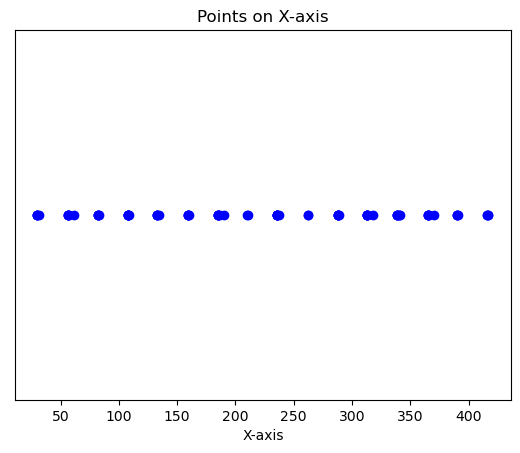

In [17]:
plt.scatter(df['top'].values, [0] * df.shape[0], marker='o', color='b')

# Adding labels
plt.xlabel('X-axis')
plt.title('Points on X-axis')

plt.gca().axes.get_yaxis().set_visible(False)

# Display the plot
plt.show()

In [ ]:
df = df.sort_values(by=['top','left']).reset_index(drop=True)
df['row'] = 1

row_id = 1
prev_val = df.iloc[0]['top']
thresh = 10

for idx in range(1,df.shape[0]):
    curr_val = df.iloc[idx]['top']
    if(curr_val-prev_val > thresh):
        print(curr_val,prev_val,curr_val-prev_val,thresh)
        row_id += 1
    prev_val = curr_val
    df.iloc[idx]['row'] = row_id
    print(df.iloc[idx]['row'])


In [ ]:
df

In [15]:
df = df.sort_values(by=['top', 'left']).reset_index(drop=True)
df['rowID'] = 1

row_id = 1
prev_val = df.loc[0, 'top']
thresh = 10

for idx in range(1, df.shape[0]):
    curr_val = df.loc[idx, 'top']
    if curr_val - prev_val > thresh:
        row_id += 1
    prev_val = curr_val
    df.at[idx, 'rowID'] = row_id
    
df['columnID'] = df.groupby('rowID')['left'].rank().astype(int)

In [16]:
df

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,rowID,columnID
0,2,107,30,42,19,388,128.515464,39.796392,2.21,1,1
1,3,154,30,98,19,937,201.500534,40.469584,5.16,1,2
2,7,372,30,85,23,892,413.839686,40.659193,3.70,1,3
3,8,462,30,57,23,538,490.334572,41.392193,2.48,1,4
4,9,524,31,74,18,712,559.702247,41.122191,4.11,1,5
...,...,...,...,...,...,...,...,...,...,...,...
80,335,78,391,119,18,1103,137.480508,401.002720,6.61,15,1
81,360,78,416,64,19,646,110.178019,426.411765,3.37,16,1
82,361,143,416,139,23,1527,212.889980,425.972495,6.04,16,2
83,363,304,417,35,18,377,320.816976,425.424403,1.94,16,3


In [ ]:
import pandas as pd

# Sample DataFrame
data = {
    'label_id': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'left': [10, 20, 30, 40, 50, 60, 70, 80, 90],
    'top': [30, 30, 30, 40, 50, 55, 80, 85, 90],
    'width': [5, 5, 5, 10, 10, 10, 15, 15, 15],
    'height': [15, 15, 15, 20, 20, 20, 25, 25, 25],
    'row': [1, 1, 1, 2, 2, 2, 3, 3, 3],  # Assuming 'row' column is already present
}

df = pd.DataFrame(data)

# Create a new 'column' column based on 'left' value within each 'row'
df['column'] = df.groupby('row')['left'].rank().astype(int)

print(df)
